## AUROC spaced-kmer vs NB distance (Figure S6)

In [32]:
import os 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve, auc
import pickle
import seaborn as sns
from Bio import SeqIO
from os.path import isfile, join
from itertools import compress
import itertools
from scipy.stats import nbinom
import matplotlib

## train test split

In [48]:
def write_seqs_fasta(sequences, file_path):
    with open(file_path, 'w') as f:
        for i, seq in enumerate(sequences):
            print('>header', i+1, file=f)
            print(seq, file=f)

In [62]:
def fasta_split(file_name, new_path):
    input_seq_iterator = SeqIO.parse(file_name, "fasta")
    sequences = [str(record.seq) for record in input_seq_iterator]
    no_sequences = len(sequences)
    
    np.random.shuffle(sequences)
    train_seqs = sequences[:int(no_sequences*0.8)]
    test_seqs = sequences[int(no_sequences*0.8):]
    
    write_seqs_fasta(train_seqs, new_path+'_train.fasta')
    write_seqs_fasta(test_seqs, new_path+'_test.fasta')

In [63]:
file_table = pd.read_csv('../../../cbscratch/selex_taipale/ps_and_bg_file_table_first_and_last.txt', sep='\t', header=None)
fasta_path = '../../../cbscratch/selex_taipale/data_fasta/'
new_fasta_path = '../../../cbscratch/selex_taipale/fasta_split0/'

In [64]:
for i in range(len(file_table)):
    factor, bg_file, ps_file =  file_table.values[i]
    print(factor)
    fasta_split(os.path.join(fasta_path, bg_file), os.path.join(new_fasta_path, f'{factor}_bg'))
    fasta_split(os.path.join(fasta_path, ps_file), os.path.join(new_fasta_path, f'{factor}_ps'))

BOLL-rep0
BOLL-rep1
CARHSP1-rep0
CELF1-construct2-rep0
CELF1-construct2-rep1
CELF3-construct2-rep0
CELF4-rep0
CELF4-rep1
CELF4-rep2
CELF4-rep3
CELF4-construct2-rep0
CELF4-construct2-rep1
CSDA-rep0
CSDA-rep1
CSTF2-rep0
CSTF2-rep1
CSTF2-rep2
CSTF2T-rep0
DAZ1-rep0
DAZ1-rep1
DAZ1-rep2
DAZ1-rep3
DAZ1-rep4
DAZ1-construct2-rep0
DAZ1-construct2-rep1
DAZ1-construct3-rep0
DAZ3-rep0
DAZ4-rep0
DAZ4-rep1
DAZAP1-rep0
DAZAP1-rep1
DAZL-rep0
DAZL-rep1
ELAVL1-rep0
ELAVL3-rep0
ELAVL3-rep1
ELAVL4-rep0
ESRP1-construct3-rep0
ESRP1-construct3-rep1
HEXIM1-rep0
HEXIM2-rep0
HNRNPA0-rep0
HNRNPA1-rep0
HNRNPA1-rep1
HNRNPA1-rep2
HNRNPA1L2-rep0
HNRNPA3-rep0
HNRNPA3-rep1
HNRNPC-rep0
HNRNPC-rep1
HNRNPC-rep2
HNRNPCL1-rep0
HNRNPL-construct2-rep0
HNRNPL-construct2-rep1
HNRPLL-rep0
HNRPLL-rep1
IGF2BP1-rep0
IGF2BP1-rep1
IGF2BP1-construct4-rep0
IGF2BP1-construct4-rep1
KHDRBS1-rep0
KHDRBS1-rep1
KHDRBS2-rep0
KHDRBS2-rep1
KHDRBS3-rep0
KHDRBS3-rep1
LARP6-rep0
LARP6-rep1
LARP7-construct4-rep0
LARP7-construct4-rep1
MCM3AP-rep0
ME

## helper functions

In [2]:
def read_predictions(pred_file):
    pred = np.loadtxt(pred_file)
    return pred

In [3]:
def fasta_length(file_name):
    input_seq_iterator = SeqIO.parse(file_name, "fasta")
    return len([record.seq for record in input_seq_iterator])

In [4]:
def generate_kmer_inx(l = 3):
    vals = {'A':0,'C':1,'G':2,'U':3}
    kmer_inx = {}
    for p in list(itertools.product(vals.keys(), repeat=l)):
        inx = 0
        for j,base in enumerate(p):
            inx += (4**j)*vals[base] 
        kmer_inx[''.join(p)] = inx
    return kmer_inx

In [5]:
#reads the np.array files and extract the parameters
#the distance parameters (last 3) are exp'ed to stay positive
def read_params(files, param_dir):
    n_additional = 1 #non parameters saved at the end
    n_exped = 3 #parameters kept positive through log exp trick
    params = []
    for f in files:
        param = np.loadtxt(join(param_dir, f))
        param[-n_additional-n_exped:-n_additional] = np.exp(param[-n_additional-n_exped:-n_additional])
        param[-n_additional-1] = param[-n_additional-1]/(1+param[-n_additional-1])
        params.append(param)      
    return params

In [6]:
def read_distance_params(keywords, param_dir):    
    dist_params = []
    
    for i, keyw in enumerate(keywords):
                           
        param_files = [f for f in os.listdir(param_dir) if isfile(join(param_dir, f))]

        to_pick = [s.startswith(keyw) & s.endswith('.txt') for s in param_files]
        param_files = list(compress(param_files, to_pick))
        adam_params = read_params(param_files, param_dir)
        
        k=3
        kmer_inx = generate_kmer_inx(l=k)
        inx_kmer = {y:x for x,y in kmer_inx.items()}

        colnames = [inx_kmer[i] for i in range(len(inx_kmer))] + [inx_kmer[i] for i in range(len(inx_kmer))] + ['sf', 'r', 'p'] + ['LL']
        data = pd.DataFrame(adam_params, columns=colnames)
        r = data.sort_values(by='LL')['r'].values[0]
        p = data.sort_values(by='LL')['p'].values[0]
                           
        dist_params.append([r,p])
    return dist_params

In [33]:
def prob_distanced(factors_all, param_dir, thr):

    dist_params = read_distance_params(keywords=factors_all, param_dir=param_dir)
    p_distanced = []
    for r,p in dist_params:
        p_distanced.append(1 - nbinom.cdf(thr, r, p))

    factors = [f.split('-')[0] for f in factors_all]

    #make a dataframe and split it based on ids
    df = pd.DataFrame({'probs':p_distanced, 'factors':factors}) 

    factors_prob = {}
    for identifier, df in df.groupby('factors'):
        #keep the max value in each split
        final_prob = df.loc[:,'probs'].mean()
        factors_prob[identifier] = final_prob
    
    return factors_prob

In [114]:
def distance_mode(factors_all, param_dir):

    dist_params = read_distance_params(keywords=factors_all, param_dir=param_dir)
    mode_list = []
    for r,p in dist_params:
        mode_list.append(max(0,int(((1-p)*(r-1))/p)))
    
    return mode_list

In [8]:
file_table = pd.read_csv('../../../cbscratch/selex_taipale/ps_and_bg_file_table_first_and_last.txt', sep='\t', header=None)
fasta_path = '../../../cbscratch/selex_taipale/fasta_split_first_and_last/'
count_table = []
for i in range(len(file_table)):
    factor = file_table.iloc[i,0]
    ps_file = os.path.join(fasta_path, f'{factor}_test_ps.fasta')
    ps_no = fasta_length(ps_file)
    
    bg_file = os.path.join(fasta_path, f'{factor}_test_bg.fasta')
    bg_no = fasta_length(bg_file)
    
    count_table.append([factor, ps_no, bg_no])

## based spaced k-mer model

In [127]:
mode_list = distance_mode(np.array(count_table)[:,0], nb_path)
auc_list = []

for i in range(len(count_table)):
    
    factor, ps_no, bg_no = count_table[i]
    k = min(mode_list[i] + 6, 12)
    
    fpr = []
    tpr = []

    k_path = f'param/selex_nodist0_1000/selex_spaced_{k}mers/'
    nb_file = os.path.join(nb_path, f'{factor}.predictions')
    k_file = os.path.join(k_path, f'{factor}.predictions')
    
    y_true = np.concatenate([np.ones(ps_no), np.zeros(bg_no)])

    auc_nb = comp_auc(nb_file, y_true)
    auc_k = comp_auc(k_file, y_true)

    auc_list.append([auc_nb, auc_k])  

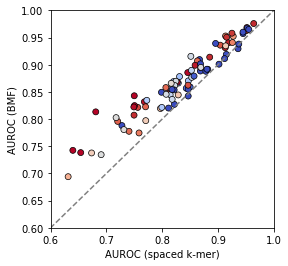

In [128]:
datasets = ['BMF', 'spaced k-mer']
factors = [c[0] for c in count_table]
plotting_dir = 'kmer_vs_nb'

#combine replicates to one AUROC number per RBP

metric_df = pd.DataFrame(auc_list, columns=datasets)
metric_df['factors'] = [c.split('-')[0] for c in factors]
factors_unique = []
metric_by_factor = {}
for label, df in metric_df.groupby('factors'):
    factors_unique.append(label)
    values = df.replace(0, np.NaN).mean()
    metric_by_factor[label] = values

metric_by_factor = pd.DataFrame(metric_by_factor).T.loc[:,datasets].values
metric_by_factor = np.array(metric_by_factor)
metric_by_factor.shape


cmap = matplotlib.cm.get_cmap('coolwarm')
col_values = []
for factor in factors_unique:
    col_values.append(factors_prob[factor])
col_values = (col_values-min(col_values))/(max(col_values)-min(col_values))
colors = [cmap(c) for c in col_values]

fig, ax = plt.subplots(figsize=(4,4))
_ = ax.scatter(metric_by_factor[:,1],metric_by_factor[:,0],c=colors, linewidths=0.7, edgecolor='black')
_ = ax.set_xlim(0.6,1)
_ = ax.set_ylim(0.6,1)
_ = ax.plot([0,1],[0,1],ls='--',color='grey')
_ = ax.set_xlabel(f'AUROC ({datasets[1]})')
_ = ax.set_ylabel(f'AUROC ({datasets[0]})')
            
plt.savefig(os.path.join(plotting_dir,'auroc_nb_bestk.pdf'), bbox_inches='tight')

## Compare the effet of max_iterations

In [71]:
nb500_path = 'param/selex_nodist0_500/split_selex_cs3/'
nb1000_path = 'param/selex_nodist0_1000/split_selex_cs3/'
nb1500_path = 'param/selex_nodist0_1500/split_selex_cs3/'

In [73]:
def comp_auc(file, y_true):
    if os.path.isfile(file):
        y_comp = read_predictions(file)
        auc_comp = roc_auc_score(y_true, y_comp)
    else:
        print(f'predictions not found (runtime error)')
        auc_comp = np.nan
    return auc_comp


auc_list = []

for i in range(len(count_table)):
    
    factor, ps_no, bg_no = count_table[i]
    
    fpr = []
    tpr = []

    nb500_file = os.path.join(nb500_path, f'{factor}.predictions')
    nb1000_file = os.path.join(nb1000_path, f'{factor}.predictions')
    nb1500_file = os.path.join(nb1500_path, f'{factor}.predictions')
    
    y_true = np.concatenate([np.ones(ps_no), np.zeros(bg_no)])

    auc_nb05 = comp_auc(nb500_file, y_true)
    auc_nb10 = comp_auc(nb1000_file, y_true)
    auc_nb15 = comp_auc(nb1500_file, y_true)

    auc_list.append([auc_nb05, auc_nb10, auc_nb15])  

In [74]:
plotting_dir = 'max_iter'

In [75]:
datasets = ['500 iterations', '1000 iterations', '1500 iterations']
factors = [c[0] for c in count_table]

In [76]:
metric_df = pd.DataFrame(auc_list, columns=datasets)
metric_df['factors'] = [c.split('-')[0] for c in factors]
factors_unique = []
metric_by_factor = {}
for label, df in metric_df.groupby('factors'):
    factors_unique.append(label)
    values = df.replace(0, np.NaN).mean()
    metric_by_factor[label] = values

metric_by_factor = pd.DataFrame(metric_by_factor).T.loc[:,datasets].values
metric_by_factor = np.array(metric_by_factor)
metric_by_factor.shape

(86, 3)

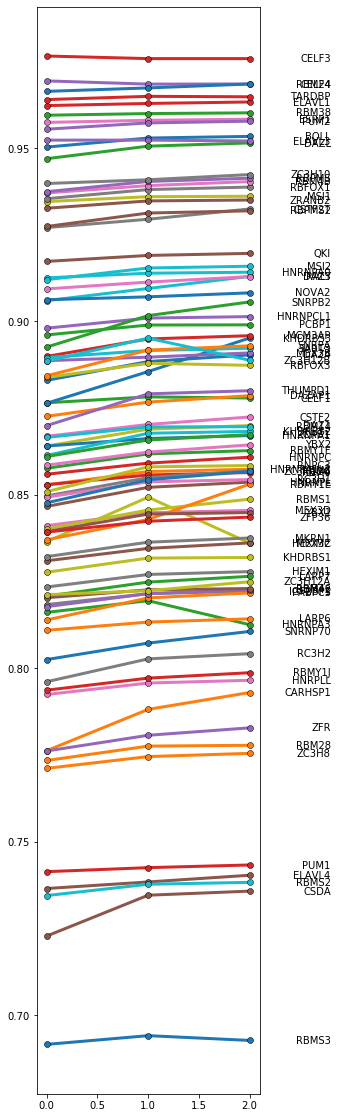

In [78]:
fig, ax = plt.subplots(figsize=(4,20))
xpos = np.arange(3)

for i, factor in enumerate(factors_unique):
    ax.plot(xpos,metric_by_factor[i], 'o-',lw=3,
            markeredgecolor='black',markeredgewidth=0.5)
    ax.text(2.8,metric_by_factor[i][-1], factor, horizontalalignment='right', 
             fontsize=10,
             verticalalignment='center')

## Compare iterations

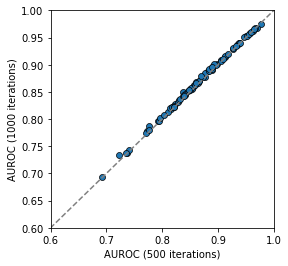

In [80]:
fig, ax = plt.subplots(figsize=(4,4))
_ = ax.scatter(metric_by_factor[:,0],metric_by_factor[:,1], linewidths=0.7, edgecolor='black')
_ = ax.set_xlim(0.6,1)
_ = ax.set_ylim(0.6,1)
_ = ax.plot([0,1],[0,1],ls='--',color='grey')
_ = ax.set_xlabel(f'AUROC ({datasets[0]})')
_ = ax.set_ylabel(f'AUROC ({datasets[1]})')
            
plt.savefig(os.path.join(plotting_dir,'1000vs500.pdf'), bbox_inches='tight')

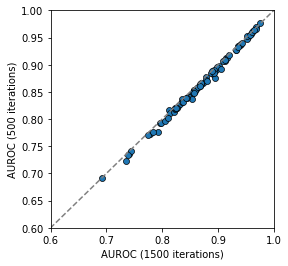

In [81]:
fig, ax = plt.subplots(figsize=(4,4))
_ = ax.scatter(metric_by_factor[:,2],metric_by_factor[:,0], linewidths=0.7, edgecolor='black')
_ = ax.set_xlim(0.6,1)
_ = ax.set_ylim(0.6,1)
_ = ax.plot([0,1],[0,1],ls='--',color='grey')
_ = ax.set_xlabel(f'AUROC ({datasets[2]})')
_ = ax.set_ylabel(f'AUROC ({datasets[0]})')
            
plt.savefig(os.path.join(plotting_dir,'1500vs500.pdf'), bbox_inches='tight')

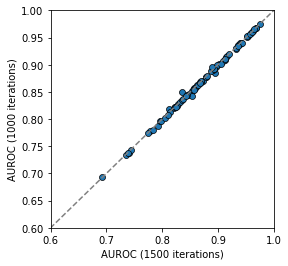

In [82]:
fig, ax = plt.subplots(figsize=(4,4))
_ = ax.scatter(metric_by_factor[:,2],metric_by_factor[:,1], linewidths=0.7, edgecolor='black')
_ = ax.set_xlim(0.6,1)
_ = ax.set_ylim(0.6,1)
_ = ax.plot([0,1],[0,1],ls='--',color='grey')
_ = ax.set_xlabel(f'AUROC ({datasets[2]})')
_ = ax.set_ylabel(f'AUROC ({datasets[1]})')
            
plt.savefig(os.path.join(plotting_dir,'1500vs1000.pdf'), bbox_inches='tight')

## Preprocess sequences

In [87]:
seq_table = pd.read_csv('protein_sequenes.txt', sep='\t', header=None)

In [88]:
with open('protein_sequenes.fasta','w') as f:
    for i in range(len(seq_table)):
        f.write(f'>{seq_table.iloc[i,0]}\n')
        sequence = ''.join(ch for ch in seq_table.iloc[i,1] if ch.isalnum())
        f.write(f'{sequence}\n')

In [90]:
hmmer = pd.read_csv('hmmer.txt', sep='\t')

In [91]:
hmmer.head()

,seq id,alignment start,alignment end,envelope start,envelope end,hmm acc,hmm name,hmm start,hmm end,hmm length,bit score,Individual E-value,Conditional E-value,database significant,outcompeted,clan
0,BOLL,35,103,35,104,PF00076.22,RRM_1,1,69,70,72.22,2.200000e-20,1.200000e-24,1,0,CL0221
1,CARHSP1,64,127,63,129,PF00313.22,CSD,2,64,66,46.28,2.800000e-12,1.600000e-16,1,0,CL0021
2,CELF1,15,79,15,83,PF00076.22,RRM_1,1,64,70,56.47,1.800000e-15,1.000000e-19,1,0,CL0221
3,CELF1,309,379,309,379,PF00076.22,RRM_1,1,70,70,66.32,1.500000e-18,8.600000e-23,1,0,CL0221
4,CELF3,15,80,15,83,PF00076.22,RRM_1,1,65,70,56.70,1.600000e-15,8.700000e-20,1,0,CL0221


In [102]:
hmmer_by_factor = {}
for label, df in hmmer.groupby('seq id'):
    domains = df['hmm name'].values
    hmmer_by_factor[label] = domains
hmmer_by_factor = pd.Series(hmmer_by_factor)

In [104]:
with open('hmmer_by_factor.txt','w') as f:
    for i in range(len(hmmer_by_factor)):
        factor = hmmer_by_factor.index[i]
        domains = ', '.join(hmmer_by_factor.values[i])
        f.write(f'{factor}\t{domains}\n')

In [103]:
', '.join(['a','b','c'])

'a, b, c'